# Classification test

In [266]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [267]:
df = pd.read_csv("data/BTCUSDT-hour-target-features.csv")
# df = pd.read_csv("data/BTCUSDT-hour-predict.csv")
# dfd = pd.read_csv("data/classification_test.csv")

In [268]:
len(df)

32890

In [269]:
# a = df1["sma_close_50"][500:1000] == df["sma_50_o_close"][500:1000]
# a.value_counts()

In [270]:
# df1["sma_close_50"][500:1000], df["sma_50_o_close"][500:1000]

In [271]:
indicators = list(df.columns)[13:]
indicators.append("target")

In [272]:
indicators = ['volume_nvi_o_close_rate_50',
 'mom_srsi_10_d',
 'bb',
 'volatility_dc_wband_10',
 'volatility_bb_pband_100',
 'volatility_bb_wband_200',
 'trend_trix_20_log',
 'trend_vi_50_amp',
 'mom_rsi_30',
 'volume_cmf_50_rate_200',
 'trend_sma_200_diff_o_close_log',
 'mom_ppo_30_hist',
 'trend_sma_50_diff_log',
 'target']

In [273]:
d = df.copy()
d.dropna(inplace=True)
ft_split = 2000
close = d["close"][-ft_split:]

d = d[list(indicators)].copy().astype(np.float32)

X = d.drop(["target", "close"], axis=1, errors="ignore")[:-ft_split]
y = d["target"][:-ft_split]

X_ft = d.drop(["target", "close"], axis=1, errors="ignore")[-ft_split:]
y_ft = d["target"][-ft_split:]

In [274]:
# X_ft_c = X_ft.copy()
# X_ft_c["close"] = close
# X_ft_c.to_csv("data/modelv1.1_testing.csv", index=False)

In [275]:
# X_ft.info()

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [277]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Precision bug documentation

- Not assigning 

Text(-1.5, 0.5, 'Predicted label')

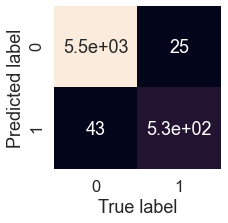

In [278]:
y_preds = model.predict(X_test)	

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True,
                 cbar=False)
plt.xlabel("True label")
plt.ylabel("Predicted label")

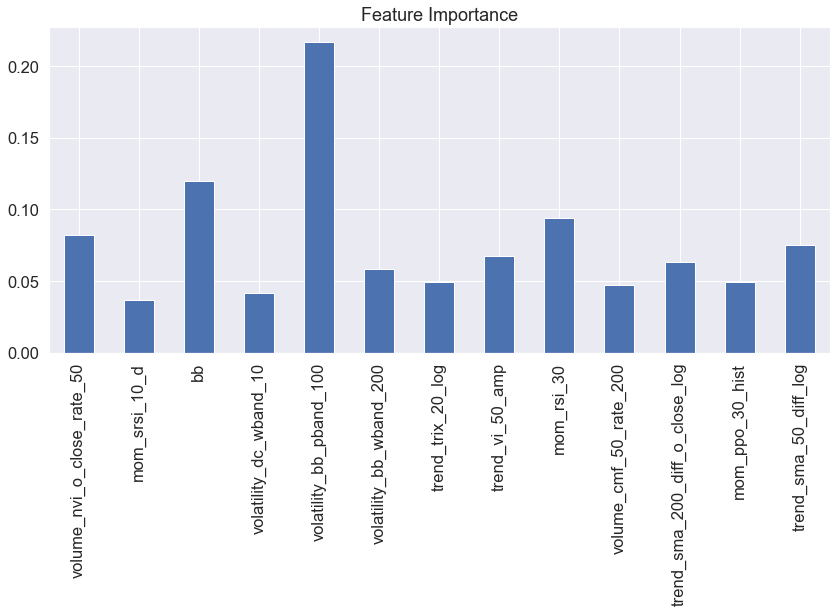

In [279]:
feature_dict = dict(zip(X_train.columns, list(model.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(14, 6));

In [281]:
d = {}
d["precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='precision'))
d

{'precision': 0.6397787545804158}

In [282]:
d["recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='recall'))
d

{'precision': 0.6397787545804158, 'recall': 0.5762484027600306}

In [283]:
d["f1"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))
d

{'precision': 0.6397787545804158,
 'recall': 0.5762484027600306,
 'f1': 0.5696671348414297}

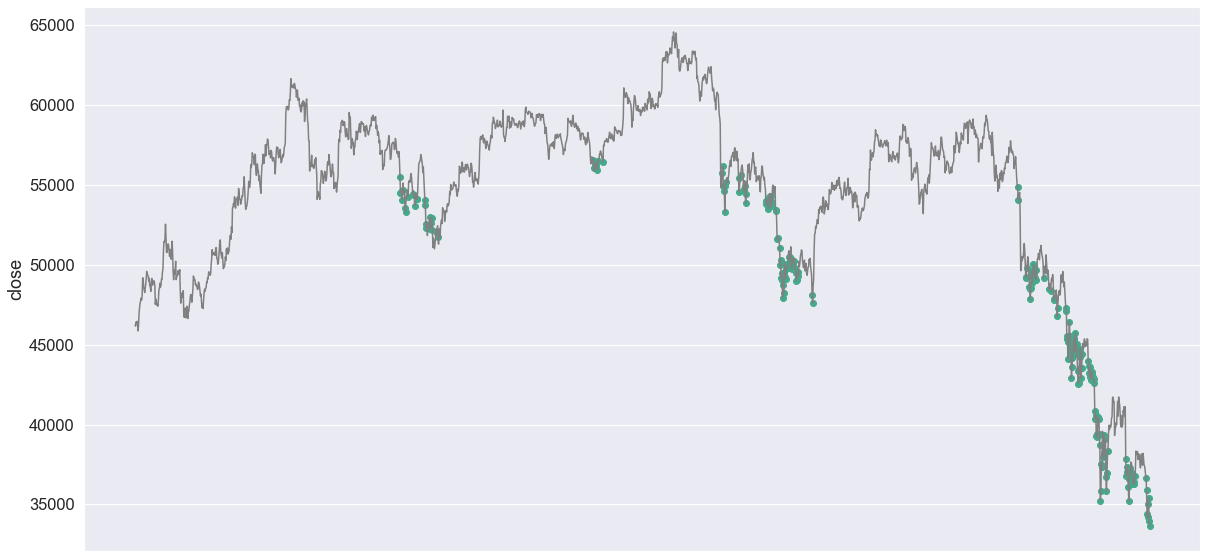

In [280]:
results = model.predict(X_ft)
scatter_results = list(map(lambda x, c: c if x == 1 else None, results, close))

s_correct = list(map(lambda x, t, c: c if x == 1 and t == 1 else None, results, y_ft, close))
s_wrong = list(map(lambda x, t, c: c if x == 1 and t == 0 else None, results, y_ft, close))
s_missed = list(map(lambda x, t, c: c if x == 0 and t == 1 else None, results, y_ft, close))

fig,ax = plt.subplots(figsize=(20, 10))

rows = len(close)
ax.scatter(range(rows), 
            scatter_results,
            color="#43aa8b")


# ax.scatter(range(rows), 
#             s_missed,
#         color="#f9c74f")

# ax.scatter(range(rows), 
#             s_correct,
#         color="#43aa8b")

# ax.scatter(range(rows), 
#             s_wrong,
#         color="#f94144")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(range(rows),
        close,
        color="gray")

ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

## Documentation of scores
| Modules (in order) | Precision (cv=5) E=error| F1 | TP:FP (TP/FP) | Notes |
| --- | :---: | :---: | :---: | --- |
| ` ` `sma` ` ` `volatility` `volume` | E:0. | 0. | 180/97 | |
| `momentum` `sma` `trend-` `volatility` `volume` | E:0. | 0. |  | |



| `momentum` `sma` `trend-` `volatility` `volume` | E:0. | 0. |  | |



In [209]:
from joblib import dump, load

In [210]:
dump(model, 'models/model_v2.test.joblib') 

['models/model_v2.test.joblib']